# **FINE TUNING RES-NET18 IN PYTORCH**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Imports and Setup**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split

# **Data Preprocessing**

In [3]:
data_dir = "/content/drive/MyDrive/BSFYP-25/BalancedActivePulmonaryTBData"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean/std
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes

# Split 80% train, 20% val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# **Load ResNet18**

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(pretrained=True)

# Freeze earlier layers (optional)
for param in resnet.parameters():
    param.requires_grad = False

# Replace final FC layer for 3-class output
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 3)  # 3 classes: Active, Obsolete, Healthy
resnet = resnet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]


# **Loss Function, Optimizer**

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)  # Only train final layer

# **Training Loop**

In [6]:
num_epochs = 10

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss:.4f} | Train Acc: {train_acc:.2f}%")

Epoch 1/10 | Loss: 61.6884 | Train Acc: 60.75%
Epoch 2/10 | Loss: 45.3358 | Train Acc: 71.67%
Epoch 3/10 | Loss: 41.0477 | Train Acc: 74.88%
Epoch 4/10 | Loss: 37.4875 | Train Acc: 77.67%
Epoch 5/10 | Loss: 36.4281 | Train Acc: 77.67%
Epoch 6/10 | Loss: 35.4055 | Train Acc: 78.96%
Epoch 7/10 | Loss: 34.1363 | Train Acc: 79.46%
Epoch 8/10 | Loss: 32.6970 | Train Acc: 80.88%
Epoch 9/10 | Loss: 33.7095 | Train Acc: 79.12%
Epoch 10/10 | Loss: 32.8077 | Train Acc: 80.33%


# **Evaluation For ResNet18**

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Get Predictions From Validation Set**

In [8]:
resnet.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = resnet(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
        all_probs.extend(probs)

# **Classification Report**

In [9]:
class_labels = dataset.classes

print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_labels))

📊 Classification Report:
                               precision    recall  f1-score   support

           ActiveTuberculosis       0.69      0.63      0.66       202
ObsoletePulmonaryTuberculosis       0.69      0.73      0.71       211
                       health       0.94      0.96      0.95       187

                     accuracy                           0.77       600
                    macro avg       0.77      0.77      0.77       600
                 weighted avg       0.76      0.77      0.76       600



# **Confusion Matrix**

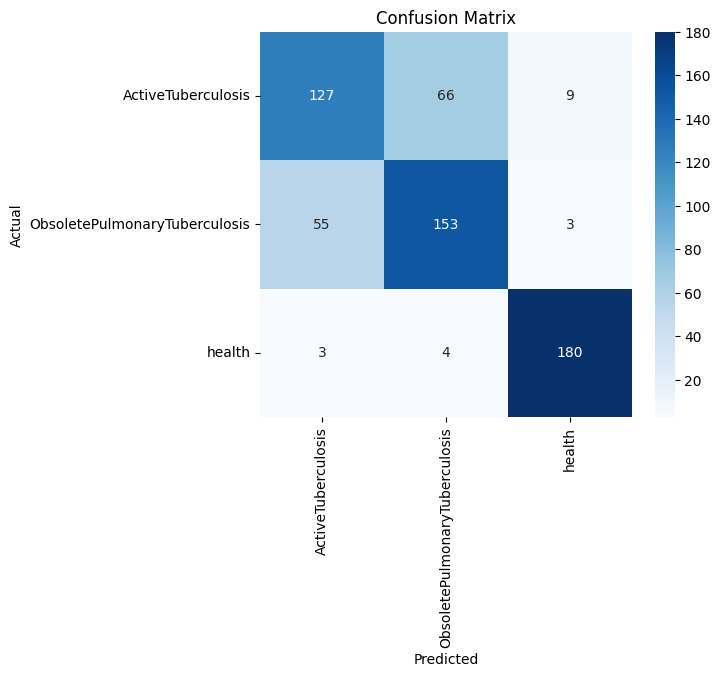

In [10]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **AUC-ROC Score**

In [11]:
# Binarize true labels
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
y_score = np.array(all_probs)

auc_score = roc_auc_score(y_true_bin, y_score, average='macro', multi_class='ovr')
print(f"🔥 AUC-ROC (macro-average): {auc_score:.4f}")

🔥 AUC-ROC (macro-average): 0.9020


# **Saving The Pytorch Model**

In [12]:
torch.save(resnet.state_dict(), 'resnet18_tuberculosis.pth')

In [13]:
torch.save(resnet, 'resnet18_full_model.pt')

In [14]:
from google.colab import files
files.download("resnet18_tuberculosis.pth")  # or "resnet18_full_model.pt"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **To Improve Accuracy**

In [15]:
# Unfreeze all layers
for param in resnet.parameters():
    param.requires_grad = True

# Optionally freeze just first few layers (e.g., up to layer1)
for name, param in resnet.named_parameters():
    if "layer1" in name:
        param.requires_grad = False

In [16]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

# **Model Performance Improvement**

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

# === CONFIG ===
data_dir = "/content/drive/MyDrive/BSFYP-25/BalancedActivePulmonaryTBData"  # UPDATE THIS
batch_size = 32
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight, reduction='none')

    def forward(self, input, target):
        ce_loss = self.ce(input, target)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

In [29]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes

# 80/20 split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [30]:
resnet = models.resnet18(pretrained=True)

# Unfreeze ALL layers
for param in resnet.parameters():
    param.requires_grad = True

# Replace FC layer for 3 classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 3)
resnet = resnet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
# Class weights: boost TB classes
weights = torch.tensor([2.0, 2.0, 1.0]).to(device)
criterion = FocalLoss(gamma=2.0, weight=weights)

optimizer = optim.Adam(resnet.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [32]:
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    scheduler.step()

    train_acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss:.4f} | Train Acc: {train_acc:.2f}%")

Epoch 1/20 | Loss: 38.6526 | Train Acc: 79.83%
Epoch 2/20 | Loss: 6.5661 | Train Acc: 97.12%
Epoch 3/20 | Loss: 1.2477 | Train Acc: 99.62%
Epoch 4/20 | Loss: 0.3414 | Train Acc: 99.96%
Epoch 5/20 | Loss: 0.2992 | Train Acc: 100.00%
Epoch 6/20 | Loss: 0.1444 | Train Acc: 100.00%
Epoch 7/20 | Loss: 0.0988 | Train Acc: 100.00%
Epoch 8/20 | Loss: 0.0607 | Train Acc: 100.00%
Epoch 9/20 | Loss: 0.1526 | Train Acc: 99.92%
Epoch 10/20 | Loss: 0.1106 | Train Acc: 100.00%
Epoch 11/20 | Loss: 0.2430 | Train Acc: 99.96%
Epoch 12/20 | Loss: 0.0557 | Train Acc: 100.00%
Epoch 13/20 | Loss: 0.0310 | Train Acc: 100.00%
Epoch 14/20 | Loss: 0.0992 | Train Acc: 99.88%
Epoch 15/20 | Loss: 0.0696 | Train Acc: 100.00%
Epoch 16/20 | Loss: 0.0554 | Train Acc: 100.00%
Epoch 17/20 | Loss: 0.0321 | Train Acc: 100.00%
Epoch 18/20 | Loss: 0.0359 | Train Acc: 100.00%
Epoch 19/20 | Loss: 0.0354 | Train Acc: 100.00%
Epoch 20/20 | Loss: 0.0269 | Train Acc: 100.00%


In [33]:
resnet.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = resnet(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
        all_probs.extend(probs)

In [34]:
class_labels = dataset.classes  # ['ActiveTuberculosis', 'ObsoletePulmonaryTuberculosis', 'health']

print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_labels))

📊 Classification Report:
                               precision    recall  f1-score   support

           ActiveTuberculosis       0.91      0.81      0.86       215
ObsoletePulmonaryTuberculosis       0.83      0.90      0.86       191
                       health       0.96      0.99      0.98       194

                     accuracy                           0.90       600
                    macro avg       0.90      0.90      0.90       600
                 weighted avg       0.90      0.90      0.90       600



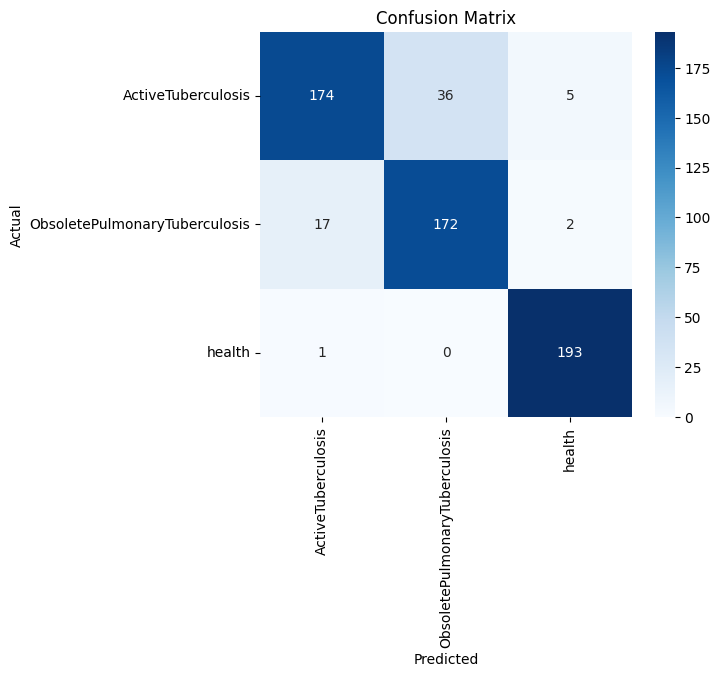

In [35]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [36]:
# Binarize labels for multiclass ROC
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
y_score = np.array(all_probs)

auc_score = roc_auc_score(y_true_bin, y_score, average='macro', multi_class='ovr')
print(f"🔥 AUC-ROC (macro-average): {auc_score:.4f}")

🔥 AUC-ROC (macro-average): 0.9815


In [37]:
torch.save(resnet.state_dict(), "resnet18_tb_final.pth")